# Exploring transfer learning

Bertrand Thia (bt2513)

In this notebook, we are going to try to improve the performances of our model by using an already existing and known architecture, and use transfer learning.

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from keras.preprocessing import image
from keras.applications import VGG16
from keras.utils import to_categorical

np.random.seed(0)

Using TensorFlow backend.


# Loading the data and data preprocessing

In [2]:
train_labels = pd.read_csv('../train.csv')

### Splitting into training set and validation set 

In [3]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [4]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [5]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

Let's load and standardized our data. To address the overfitting issue, we are going to use data augmentation here. This will allow us to increase the size of our dataset, but also make the classification more challenging. Since our dataset is small, we are just going to use some small image rotation:

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Let's use the same parameters as previously:

In [7]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (W, H),
                                            batch_size= BATCH_SIZE, 
                                            shuffle= False)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        shuffle= False)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to use the network VGG16 and pre-trained weights from the ImageNet dataset:

In [3]:
model = VGG16(include_top=False, weights='imagenet')

As it is very expansive to run the whole network, we are going to only do it once and save the output at the end of the pre-trained part of the network. We will then train fully-connected layers for the top layers of the model.

In [19]:
bottleneck_features_train = model.predict_generator(X_train, steps= len(train_set) // BATCH_SIZE)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_val = model.predict_generator(X_val, steps= len(valid_set) // BATCH_SIZE)
np.save(open('bottleneck_features_val.npy', 'wb'), bottleneck_features_val)

### Training the top layers 

In [10]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_y = to_categorical(train_set['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}).values[:-5])

validation_data = np.load(open('bottleneck_features_val.npy', 'rb'))
validation_y = to_categorical(valid_set['label'].map({'bacterial': 0, 'covid': 1, 
                                                     'normal': 2, 'viral': 3}).values[:-2])

In [11]:
print('Size of the training: %d \t labels: %d' %(len(train_data), len(train_y)))
print('Size of the validation: %d \t labels: %d' %(len(validation_data), len(validation_y)))

Size of the training: 896 	 labels: 896
Size of the validation: 224 	 labels: 224


Since we are using batches of data, we don't end up with the whole dataset, but this will allow to speed up the process.

In [60]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(units= 128, activation= 'relu')) 
top_model.add(Dropout(0.5)) 
top_model.add(Dense(units= 64, activation= 'relu')) 
top_model.add(Dropout(0.3)) 
top_model.add(Dense(units= 4, activation= 'softmax'))

top_model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(lr= 1e-4), 
              metrics = ['accuracy'])

In [28]:
epochs= 50
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
filepath="./weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [29]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [77]:
hist = top_model.fit(train_data, train_y,
                 epochs= epochs, 
                 batch_size = BATCH_SIZE,
                 verbose= 1, 
                 validation_data = (validation_data, validation_y),
                 class_weight= class_weight,
                 callbacks= [checkpoint])

Train on 896 samples, validate on 224 samples
Epoch 1/50
896/896 [==============================] - 2s 2ms/step - loss: 1.1800 - accuracy: 0.4554 - val_loss: 0.7872 - val_accuracy: 0.6250

Epoch 00001: saving model to ./weights/weights-improvement-01-0.62.hdf5
Epoch 2/50
896/896 [==============================] - 1s 1ms/step - loss: 0.8864 - accuracy: 0.6049 - val_loss: 0.7317 - val_accuracy: 0.6473

Epoch 00002: saving model to ./weights/weights-improvement-02-0.65.hdf5
Epoch 3/50
896/896 [==============================] - 1s 1ms/step - loss: 0.7767 - accuracy: 0.6496 - val_loss: 0.6716 - val_accuracy: 0.7054

Epoch 00003: saving model to ./weights/weights-improvement-03-0.71.hdf5
Epoch 4/50
896/896 [==============================] - 1s 1ms/step - loss: 0.7191 - accuracy: 0.6897 - val_loss: 0.6437 - val_accuracy: 0.7455

Epoch 00004: saving model to ./weights/weights-improvement-04-0.75.hdf5
Epoch 5/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6237 - accuracy: 0

Epoch 39/50
896/896 [==============================] - 1s 1ms/step - loss: 0.0786 - accuracy: 0.9799 - val_loss: 0.6523 - val_accuracy: 0.7946

Epoch 00039: saving model to ./weights/weights-improvement-39-0.79.hdf5
Epoch 40/50
896/896 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.9766 - val_loss: 0.6409 - val_accuracy: 0.7946

Epoch 00040: saving model to ./weights/weights-improvement-40-0.79.hdf5
Epoch 41/50
896/896 [==============================] - 1s 1ms/step - loss: 0.0680 - accuracy: 0.9866 - val_loss: 0.6800 - val_accuracy: 0.7857

Epoch 00041: saving model to ./weights/weights-improvement-41-0.79.hdf5
Epoch 42/50
896/896 [==============================] - 1s 1ms/step - loss: 0.0734 - accuracy: 0.9810 - val_loss: 0.6856 - val_accuracy: 0.7857

Epoch 00042: saving model to ./weights/weights-improvement-42-0.79.hdf5
Epoch 43/50
896/896 [==============================] - 1s 1ms/step - loss: 0.0713 - accuracy: 0.9821 - val_loss: 0.7449 - val_accuracy: 

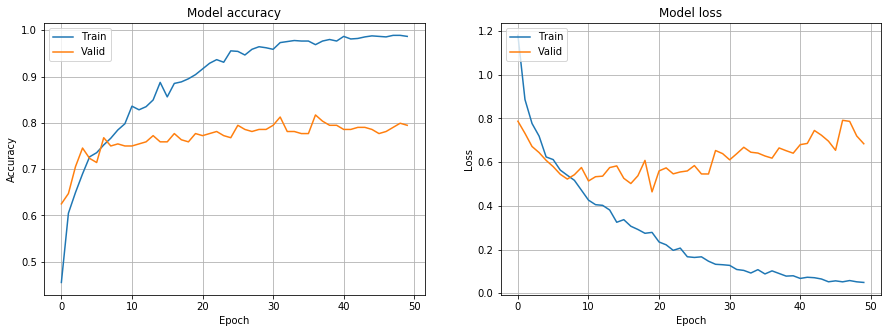

In [78]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

We can see that we were able to obtain better results than previously by using pre-trained weights!

### Evaluating our model

In [37]:
# Loading the best weights
top_model.load_weights("./weights/weights-improvement-37-0.82.hdf5")

In [38]:
evaluation = top_model.evaluate(validation_data, validation_y)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

224/224 [==============================] - 0s 587us/step
Accuracy on the validation set: 0.817


In [39]:
pred = top_model.predict(validation_data)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 0, 2, 2, 0, 0, 3, 0])

In [40]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [41]:
y_val = valid_set['label'].map(X_val.class_indices).values

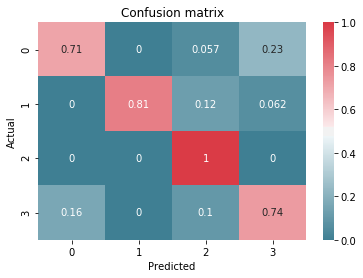

In [42]:
data = {'y_val': y_val[:-2], 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'],
                               normalize= 'index')

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [43]:
print(classification_report(y_val[:-2], y_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76        70
           1       1.00      0.81      0.90        16
           2       0.84      1.00      0.92        70
           3       0.75      0.74      0.74        68

    accuracy                           0.82       224
   macro avg       0.85      0.82      0.83       224
weighted avg       0.82      0.82      0.81       224



The performances are higher than previously without transfer learning.

# Going further: fine-tuning the top layers of the pre-trained network

We are now going to train the last convolutional layers of VGG16 to try to tailor the network a bit more to our problem and improve furthermore our results:

In [8]:
pretrained_model = VGG16(include_top=False, weights='imagenet', input_shape= (W, H, 3))

In [12]:
top_model = Sequential()
top_model.add(Flatten(input_shape=(train_data.shape[1:])))
top_model.add(Dense(units= 128, activation= 'relu')) 
top_model.add(Dropout(0.5)) 
top_model.add(Dense(units= 64, activation= 'relu')) 
top_model.add(Dropout(0.3)) 
top_model.add(Dense(units= 4, activation= 'softmax'))

top_model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(lr= 1e-4), 
              metrics = ['accuracy'])

top_model.load_weights("./weights/weights-improvement-37-0.82.hdf5")

In [13]:
model = Sequential()
model.add(pretrained_model)
model.add(top_model)

# Freezing all the layers but the last block
for layer in pretrained_model.layers[:-4]:
    layer.trainable = False

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer= SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

### Training

We are also going to use more data augmentation to make the classification more challenging and build a more robust model:

In [15]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)


X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (W, H),
                                            batch_size= BATCH_SIZE, 
                                            seed= 0)

Found 901 validated image filenames belonging to 4 classes.


In [82]:
epochs= 10

filepath="./tuning/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

In [83]:
hist = model.fit_generator(X_train,
                           epochs= epochs, 
                           steps_per_epoch= len(train_set) // BATCH_SIZE,
                           verbose= 1, 
                           validation_data = X_val,
                           validation_steps= len(valid_set) // BATCH_SIZE,
                           class_weight= class_weight,
                           callbacks= [checkpoint])

Epoch 1/10
28/28 [==============================] - 272s 10s/step - loss: 0.3155 - accuracy: 0.8841 - val_loss: 0.1701 - val_accuracy: 0.9074

Epoch 00001: saving model to ./tuning/weights-improvement-01-0.91.hdf5
Epoch 2/10
28/28 [==============================] - 260s 9s/step - loss: 0.3265 - accuracy: 0.8846 - val_loss: 0.4185 - val_accuracy: 0.8982

Epoch 00002: saving model to ./tuning/weights-improvement-02-0.90.hdf5
Epoch 3/10
28/28 [==============================] - 263s 9s/step - loss: 0.3334 - accuracy: 0.8884 - val_loss: 0.2021 - val_accuracy: 0.9111

Epoch 00003: saving model to ./tuning/weights-improvement-03-0.91.hdf5
Epoch 4/10
28/28 [==============================] - 264s 9s/step - loss: 0.3129 - accuracy: 0.8846 - val_loss: 0.3194 - val_accuracy: 0.9059

Epoch 00004: saving model to ./tuning/weights-improvement-04-0.91.hdf5
Epoch 5/10
28/28 [==============================] - 266s 9s/step - loss: 0.3350 - accuracy: 0.8728 - val_loss: 0.2110 - val_accuracy: 0.9085

Epoch

The results of the training look better than previously. Fine-tuning the top layers seem to lead to better performances.

### Evaluating our final model

In [16]:
# Loading the best weights
model.load_weights("./tuning/weights-improvement-07-0.91.hdf5")

In [17]:
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [18]:
evaluation = model.evaluate_generator(X_val2)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.906


In [19]:
pred = model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 0, 2, 2, 0, 0, 3, 0])

In [20]:
y_val = valid_set['label'].map(X_val2.class_indices).values

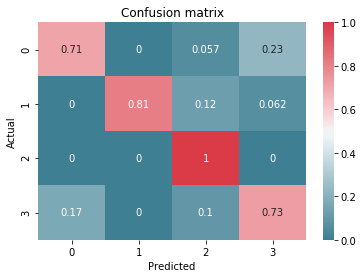

In [21]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'],
                               normalize= 'index')

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [22]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        70
           1       1.00      0.81      0.90        16
           2       0.84      1.00      0.92        70
           3       0.75      0.73      0.74        70

    accuracy                           0.81       226
   macro avg       0.85      0.81      0.83       226
weighted avg       0.81      0.81      0.81       226



Surprisingly, even though the results of the training look better, we don't observe much improvements

# Predicting on the test set

In this section, we are going to predict the labels of the test set using our improved model and save them.

### Loading the test set

In [103]:
test_df = pd.read_csv('../test.csv')

In [104]:
test_df.head()

,id,filename
0,0,test/img-0.jpeg
1,1,test/img-1.jpeg
2,2,test/img-2.jpeg
3,3,test/img-3.jpeg
4,4,test/img-4.jpeg


In [105]:
# Loading the images from the test set

n_rows = test_df.shape[0]
all_images = []

for i in range(n_rows):
    image_path = '../test2/' + test_df.loc[i, 'filename']
    img = image.load_img(image_path , target_size= (W, H))
    img = np.array(img)
    all_images.append(img)
X_test = np.array(all_images)
X_test.shape

(484, 312, 251, 3)

In [106]:
test_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

BATCH_SIZE2 = 4

def test_gen(x_test):
    Y_trash = np.ones(x_test.shape[0])
    flow = test_datagen.flow(x_test, Y_trash, batch_size= BATCH_SIZE2, shuffle= False)
    for X,Y in flow:
        yield X

In [109]:
pred = model.predict_generator(test_gen(X_test), steps= len(test_df) // BATCH_SIZE2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 1, 3, 2, 2, 0, 2, 2, 3])

In [110]:
len(y_pred)

484

### Formatting the output like the submission example

In [111]:
submission = pd.read_csv('../submission.csv')
submission.head()

,Id,label
0,0,bacterial
1,1,viral
2,2,normal
3,3,normal
4,4,bacterial


In [112]:
data = {'Id': test_df['id'], 'label': y_pred}
output = pd.DataFrame(data)
output['label'] = output['label'].map({0:'bacterial', 1: 'covid', 2: 'normal', 3: 'viral'})
output

,Id,label
0,0,bacterial
1,1,normal
2,2,covid
3,3,viral
4,4,normal
...,...,...
479,479,viral
480,480,viral
481,481,viral
482,482,viral


In [113]:
# saving the output
output.to_csv('output_best_tuned.csv', index= False)

--- 

# Appendix

### Looking into the output of the model before fine-tuning the top layers

In [12]:
model = VGG16(include_top=False, weights='imagenet')

bottleneck_features_test = model.predict_generator(test_gen(X_test),steps= len(test_df) // BATCH_SIZE2)
np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)

In [46]:
test_data = np.load(open('bottleneck_features_test.npy', 'rb'))

pred = top_model.predict(test_data)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 1, 3, 2, 2, 0, 2, 2, 3])